In [1]:
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# Function to save the graph as directional shapefiles
def save_graph_shapefile_directional(G, filepath=None, encoding="utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")

    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
    # We need an unique ID for each edge
    gdf_edges["fid"] = np.arange(0, gdf_edges.shape[0], dtype='int')
    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding=encoding)
    gdf_edges.to_file(filepath_edges, encoding=encoding)

print("osmnx version",ox.__version__)

# Download by place name
place ="Ciampino, Italy"
G = ox.graph_from_place(place, network_type='drive', which_result=1)
save_graph_shapefile_directional(G, filepath='ciampino')




osmnx version 1.9.4


C:\Users\chiar\AppData\Local\Temp\ipykernel_37560\662350455.py:24: FutureWarning: The `graph_to_gdfs` function has moved to the `convert` module. Calling `utils_graph.graph_to_gdfs` is deprecated and will be removed in the v2.0.0 release. Call it via `convert.graph_to_gdfs` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
C:\Users\chiar\AppData\Local\Temp\ipykernel_37560\662350455.py:30: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


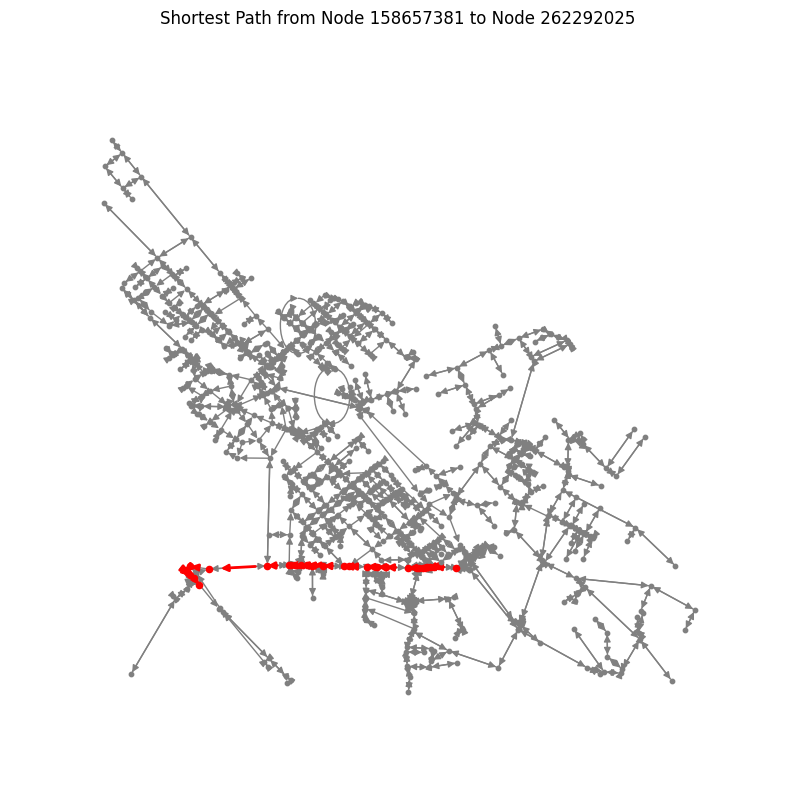

In [2]:

# Create a NetworkX graph from the nodes and edges
def create_graph_from_shapefiles(nodes_path, edges_path):
    nodes = gpd.read_file(nodes_path)
    edges = gpd.read_file(edges_path)
    G = nx.DiGraph()
    
    # Add nodes to the graph
    for _, node in nodes.iterrows():
        G.add_node(node['osmid'], pos=(node.geometry.x, node.geometry.y))
    
    # Add edges to the graph
    for _, edge in edges.iterrows():
        G.add_edge(edge['u'], edge['v'], length=edge['length'], oneway=edge['oneway'], fid=edge['fid'])
        # If the road is not one-way, add the reverse edge
        if edge['oneway'] == 0:
            G.add_edge(edge['v'], edge['u'], length=edge['length'], fid=edge['fid'])
    
    return G
# Load the graph from saved shapefiles
nodes_path = './ciampino/nodes.shp'
edges_path = './ciampino/edges.shp'
G = create_graph_from_shapefiles(nodes_path, edges_path)

# Function to calculate shortest path tree from a given node
def calculate_shortest_path_tree(G, source):
    return nx.single_source_dijkstra_path_length(G, source, weight='length'), nx.single_source_dijkstra_path(G, source, weight='length')

# Calculate and store shortest path trees for all nodes
shortest_paths = {}
for node in G.nodes:
    path_lengths, paths = calculate_shortest_path_tree(G, node)
    shortest_paths[node] = {'lengths': path_lengths, 'paths': paths}

# Function to visualize shortest path between two nodes
def visualize_shortest_path(G, shortest_paths, source, target):
    if source not in shortest_paths or target not in shortest_paths[source]['paths']:
        print("No path found between the selected nodes.")
        return
    
    path = shortest_paths[source]['paths'][target]
    
    # Extract nodes and edges for the shortest path
    path_edges = list(zip(path[:-1], path[1:]))
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the base map in grey
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, node_size=10, node_color='grey', edge_color='grey', ax=ax)
    
    # Highlight the shortest path in red
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=20, node_color='red', ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2, ax=ax)
    
    plt.title(f"Shortest Path from Node {source} to Node {target}")
    plt.show()

# Example usage: visualize the shortest path between two arbitrary nodes
source_node = list(G.nodes())[0]  # Replace with actual node id
target_node = list(G.nodes())[10]  # Replace with actual node id
visualize_shortest_path(G, shortest_paths, source_node, target_node)

# Modular components:
# - save_graph_shapefile_directional: Save the graph as shapefiles.
# - create_graph_from_shapefiles: Create a NetworkX graph from saved shapefiles.
# - calculate_shortest_path_tree: Calculate shortest path tree from a source node.
# - visualize_shortest_path: Visualize shortest path between two nodes.

# These functions can be enabled or disabled as needed, making the code modular.